In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [6]:
data = pd.read_csv("BatteryTableAllLogs.csv")

In [79]:
data.hostName.drop_duplicates()

0          44-4b-5d-01-04-19
5          44-4b-5d-01-04-41
16         44-4b-5d-01-04-29
421        44-4b-5d-01-04-79
199071     44-4b-5d-01-04-a1
587359     44-4b-5d-01-04-91
719047     44-4b-5d-01-04-09
750216     44-4b-5d-01-04-51
750220     44-4b-5d-01-04-89
1400867    44-4b-5d-01-04-21
1516076    44-4b-5d-01-04-11
2617401    44-4b-5d-01-04-81
2617403    44-4b-5d-01-04-31
3120498    44-4b-5d-01-04-b1
3178722    44-4b-5d-01-04-01
6330070    44-4b-5d-01-04-39
Name: hostName, dtype: object

In [17]:
host = '44-4b-5d-01-04-91'

In [18]:
SPO2 = data.loc[(data['hostName'] == host) & (data['device'] == 'SPO2SENSOR')].sort_values(by=['timestamp'])
RESP = data.loc[(data['hostName'] == host) & (data['device'] == 'RESPSENSOR')].sort_values(by=['timestamp'])
HUB = data.loc[(data['hostName'] == host) & (data['device'] == 'HUB')].sort_values(by=['timestamp'])

## Data Statistics

In [109]:
data.temperature.max()

39

In [113]:
data.capacity.min()

0

In [ ]:
data.temperature.max()

39

## Data Over Time

<Axes: title={'center': 'RESP Temperature 44-4b-5d-01-04-91'}, xlabel='timestamp'>

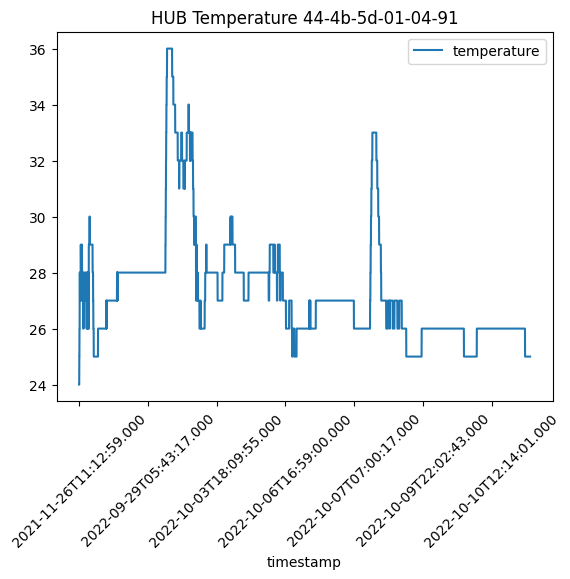

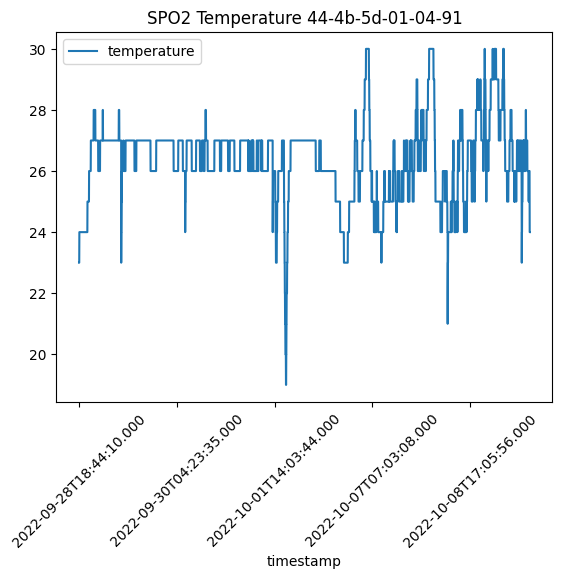

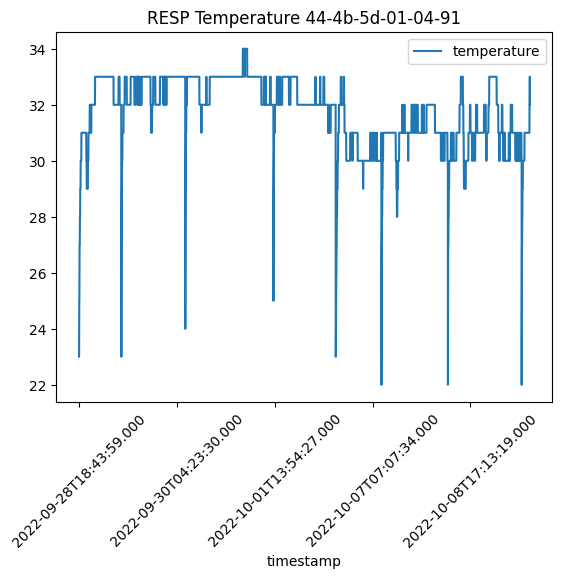

In [115]:
HUB.plot(x='timestamp', y='temperature', rot=45, title='HUB Temperature ' + host)
SPO2.plot(x='timestamp', y='temperature', rot=45, title='SPO2 Temperature ' + host)
RESP.plot(x='timestamp', y='temperature', rot=45, title='RESP Temperature ' + host)

## Temperature and Capacity

<Axes: title={'center': 'RESP Sensor Temperature 44-4b-5d-01-04-91'}, xlabel='timestamp'>

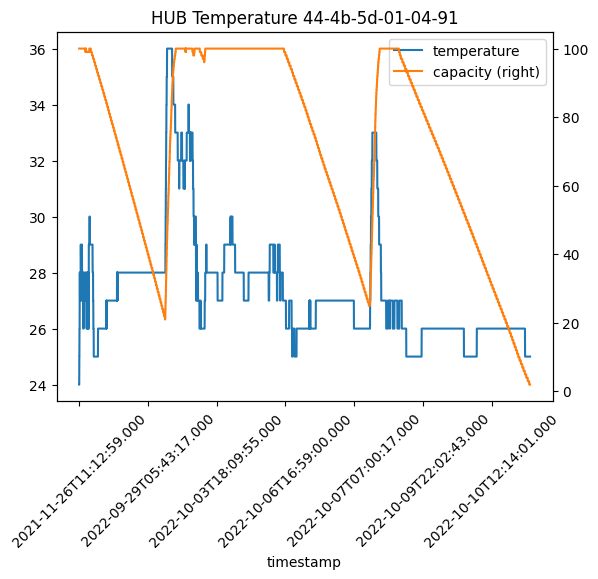

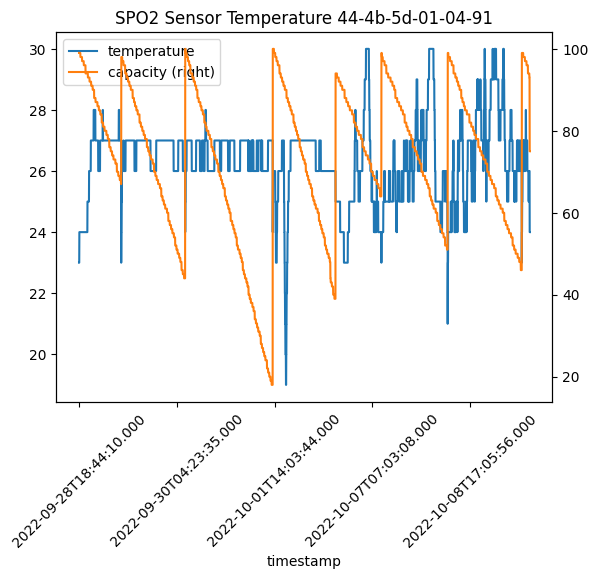

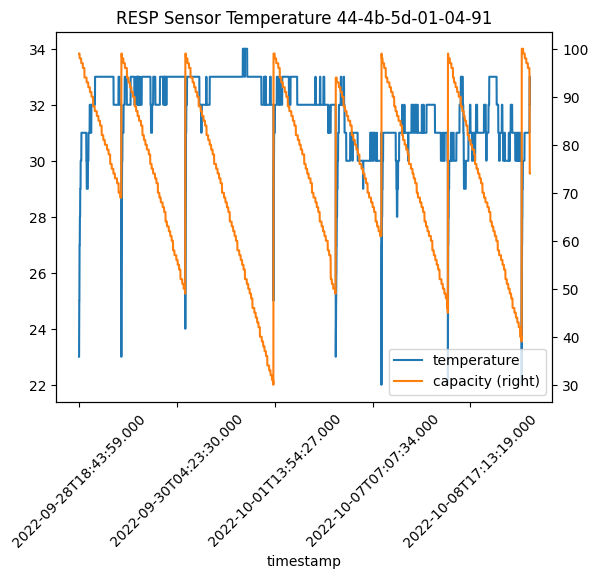

In [114]:
HUB.plot(x='timestamp', y=['temperature', 'capacity'], rot=45, title='HUB Temperature ' + host , secondary_y='capacity')
SPO2.plot(x='timestamp', y=['temperature', 'capacity'], rot=45, title='SPO2 Sensor Temperature ' + host, secondary_y='capacity')
RESP.plot(x='timestamp', y=['temperature', 'capacity'], rot=45, title='RESP Sensor Temperature ' + host, secondary_y='capacity')

# Info about Current

### 5 number summary of current in mA

In [7]:
minimum = np.min(data.current)
maximum = np.max(data.current)
q1 = np.percentile(data.current, 25)
median = np.median(data.current)
q3 = np.percentile(data.current, 75)

print("Minimum:", minimum)
print("First Quartile (Q1):", q1)
print("Median:", median)
print("Third Quartile (Q3):", q3)
print("Maximum:", maximum)

Minimum: -442
First Quartile (Q1): -102.0
Median: 0.0
Third Quartile (Q3): 0.0
Maximum: 1056


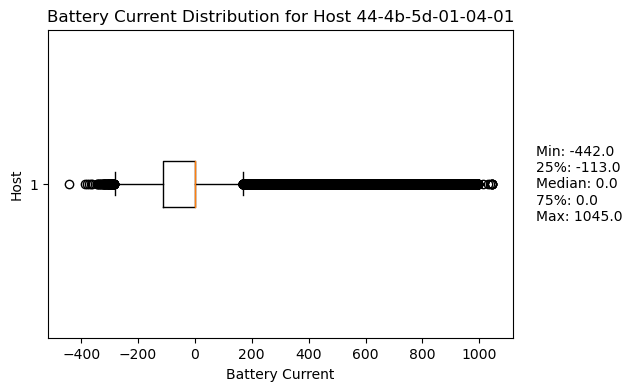

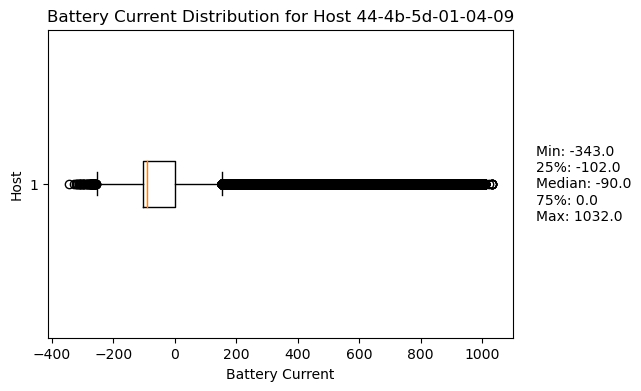

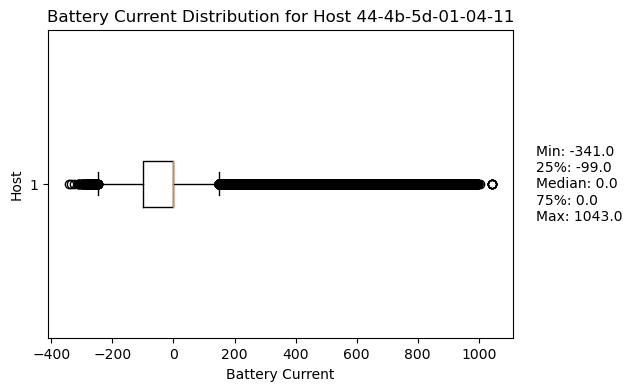

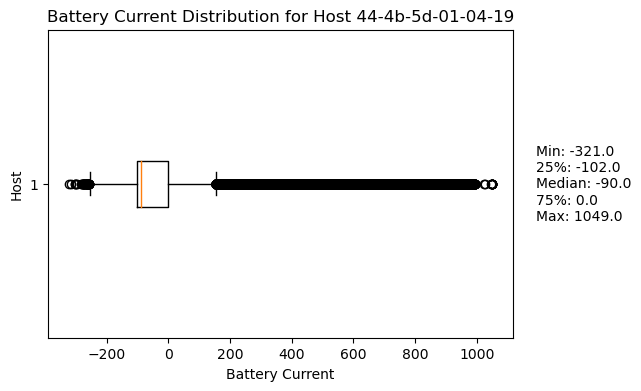

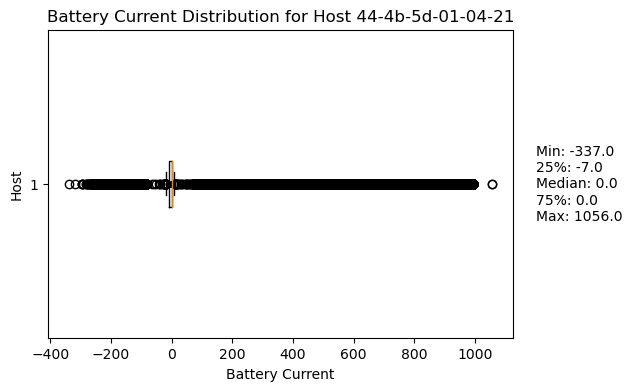

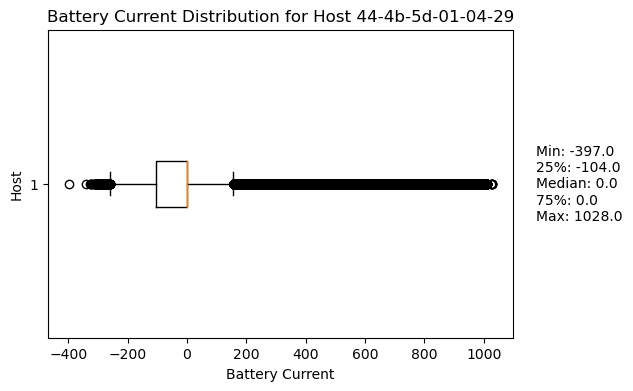

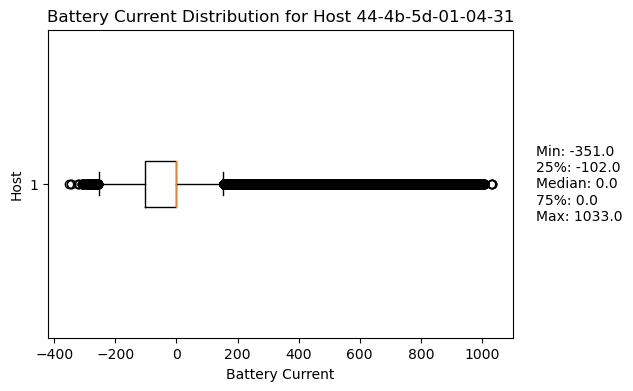

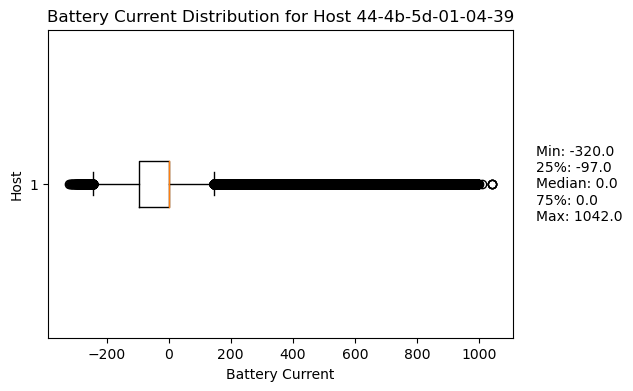

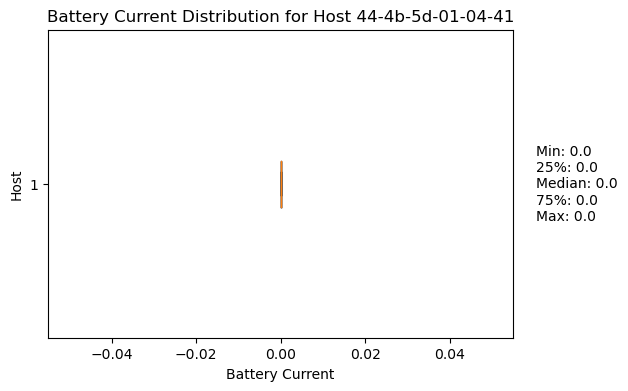

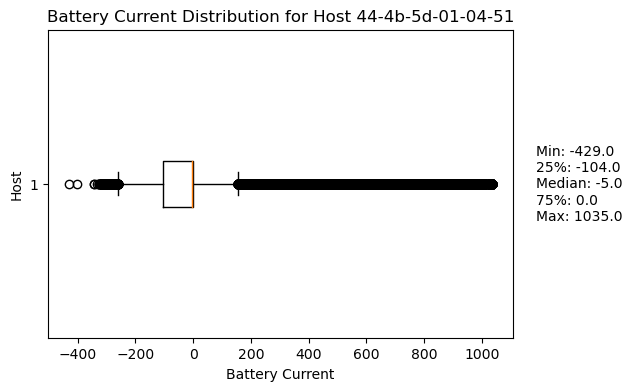

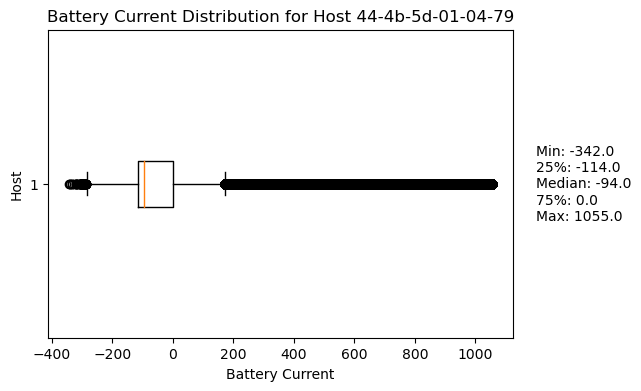

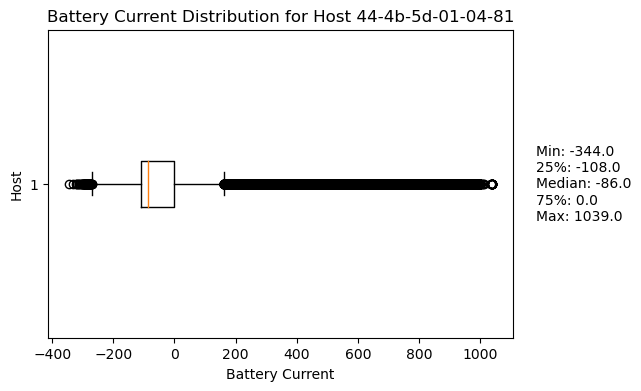

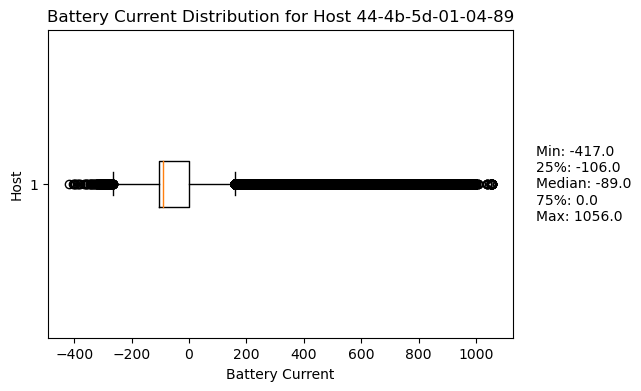

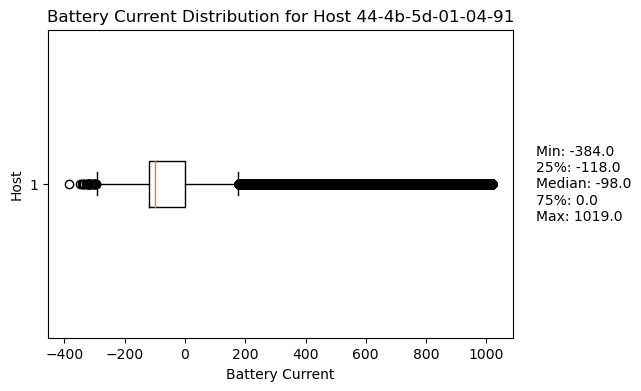

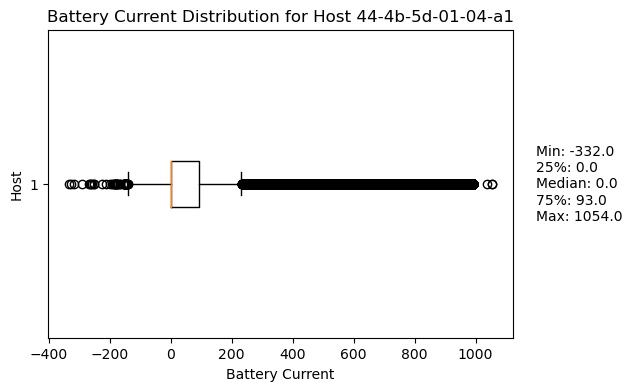

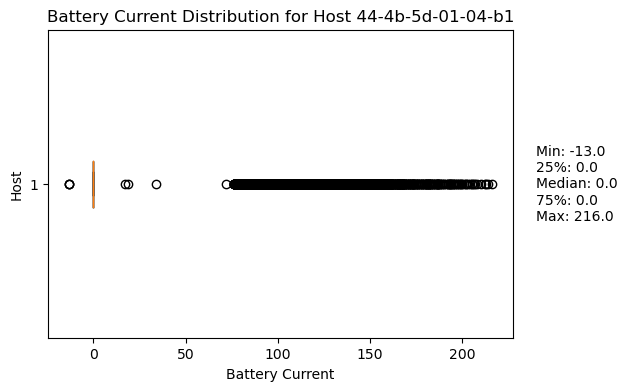

In [31]:
databy_hostname = data.groupby('hostName')

for host, group_df in databy_hostname:
    plt.figure(figsize=(6, 4))  
    plt.boxplot(group_df['current'], vert=False)
    plt.title(f'Battery Current Distribution for Host {host}')
    plt.xlabel('Battery Current')
    plt.ylabel('Host')
    
    summary = group_df['current'].describe()
    summary_text = f"Min: {summary['min']}\n25%: {summary['25%']}\nMedian: {summary['50%']}\n75%: {summary['75%']}\nMax: {summary['max']}"
    plt.text(1.05, 0.5, summary_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

    plt.show()
   

## 5 number summary for Hub, Sp02, Resp

In [35]:
device = data.groupby('device')['current']
summary = device.describe(percentiles=[.25, .5, .75])
summary

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
HUB,8057067.0,-18.958330,165.323334,-442.0,-103.0,0.0,0.0,1056.0
RESPSENSOR,141760.0,-6.074520,1.081094,-80.0,-6.0,-6.0,-6.0,-2.0
SPO2SENSOR,144450.0,-7.182811,2.527583,-62.0,-8.0,-7.0,-5.0,-2.0


#### The negative mean values suggest that on average, the devices tend to consume current rather than supply it.
#### RESPSENSOR has the lowest standard deviation (1.08), indicating less variability in battery current values. While HUB' has the highest standard deviation (165.32), implying a wider spread of battery current values compared to the other devices.
#### The maximum battery current varies across devices, with 'HUB' having the highest maximum (1056.0) and 'SPO2SENSOR' having the lowest maximum (-2.0).
#### The median (50th percentile) battery current for 'HUB' is 0.0, indicating that half of the observations have battery current values of 0.0 or lower.

### Negative is battery discharging, positive is battery charging, zero is not charging

Text(0.5, 1.0, 'Histogram of Battery Current')

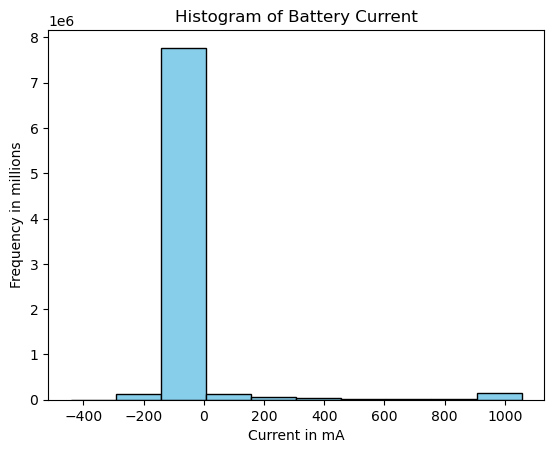

In [19]:
plt.hist(data.current, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Current in mA')
plt.ylabel('Frequency in millions')
plt.title('Histogram of Battery Current')

###### Most of the batteries are discharging or not charging

### Current over time for Hub

In [44]:
def partition(arr, low, high):
    pivot = arr[high]
    i = low - 1
    for j in range(low, high):
        if arr[j] <= pivot:
            i = i + 1
            arr[i], arr[j] = arr[j], arr[i]
    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return i + 1

def quicksort(arr, low, high):
    if low < high:
        pi = partition(arr, low, high)
        quicksort(arr, low, pi - 1)
        quicksort(arr, pi + 1, high)

In [46]:
grouped_data = data.groupby('device')